# debug.Completeness

In [1]:
from astropy.table import Table, vstack
from astropy.io.fits import getdata

import pandas as pd

import matplotlib
import numpy as np

from collections import defaultdict
from matplotlib import pylab
import matplotlib.pyplot as plt

from scipy import stats
import sklearn

import scipy.stats as st
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

In [3]:
import sys
sys.path.append('/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/')
from plotLibrary import viewMembershipSelection

root = '/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/'
vm = viewMembershipSelection(cfg=root+'config_buzzard_v2.yaml',dataset='buzzard_v2')

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00000.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00016.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00017.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00018.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00019.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00020.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00022.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00032.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00034.hdf5
/data/des61.a/data/johnny

In [48]:
runs=['gauss001_rhod_02Lstar','gauss003_rhod_02Lstar_raper100']

In [49]:
for run in runs:
    print('run: %s'%run)
    vm.load_data(run,is_bma=False)

run: gauss001_rhod_02Lstar
run: gauss003_rhod_02Lstar_raper100


In [182]:
from sklearn.metrics import precision_recall_curve

for run in runs:    
    vm.compute_precision_recall_curves(run,prob='Pmem',th='True')

Text(0.5,1,'Completeness, Purity')

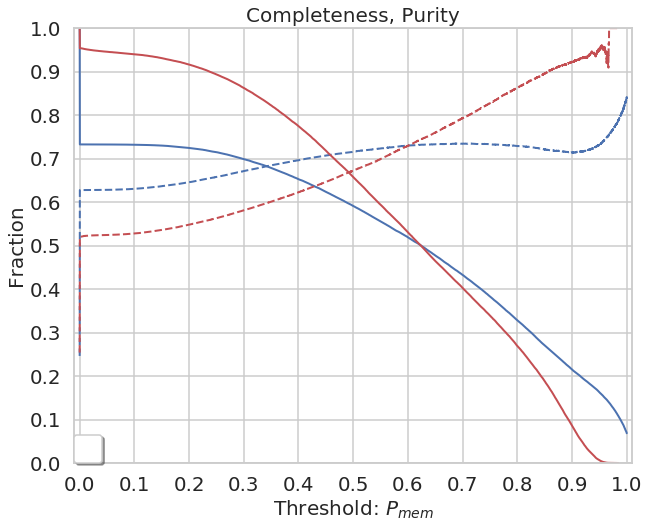

In [183]:
plt.figure(figsize=(10,8))

colors = ['b','r']
for color,run in zip(colors,runs):
    plt.axvline(-1.,color=color,lw=3)

plt.legend(fontsize=14, loc=3, shadow=True, borderaxespad=0.,ncol=int(len(runs)/2),borderpad=1)

for color,run in zip(colors,runs):
    vm.plot_precision_recall_vs_threshold(run,c1=color)
    #plt.legend()
    
plt.xlabel(r'Threshold: $P_{mem}$', fontsize=20)
plt.ylabel('Fraction', fontsize=20)
plt.title('Completeness, Purity',fontsize=20)

# save_figures(fig,99,is_tight=False)

In [52]:
gal0 = vm.datasets[runs[0]]
gal1 = vm.datasets[runs[1]]

## Zmask

Here we investigate if it's due to the redshift mask.

In [53]:
def get_zstd(data,zw=0.01):
    zoffset = data['zoffset']/(zw*(1+data['redshift']))
    return np.array(zoffset)

In [54]:
zstd0 = get_zstd(gal0,zw=0.01)
zstd1 = get_zstd(gal1,zw=0.03)

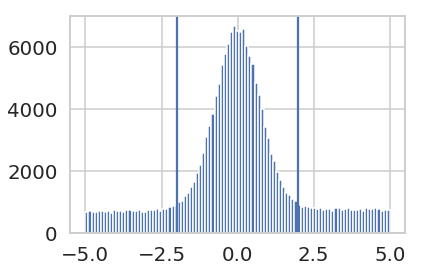

In [55]:
_ = plt.hist(zstd0,bins=np.linspace(-5.,5.,100))
plt.axvline(2.)
plt.axvline(-2.)

In [56]:
zmask0 = np.abs(zstd0)<=2.
true0 = gal0['True']
1.*np.count_nonzero(zmask0&true0)/np.count_nonzero(true0)

0.9910855482797802

In [70]:
zmask1 = np.abs(zstd1)<=2.
true1 = gal1['True']
1.*np.count_nonzero(zmask1&true1)/np.count_nonzero(true1)

0.9916346901257264

The issue is not due to the photo-z mask.

## Missing Galaxies

In [71]:
pmask0 = gal0['Pmem']<0.01
1.*np.count_nonzero(pmask0&true0)/np.count_nonzero(true0)

0.26741012334977216

In [76]:
pmask1 = gal1['Pmem']<0.01
1.*np.count_nonzero(pmask1&true1)/np.count_nonzero(true1) # it's in agreement with the photo-z distribution

0.04825475946649558

Why do we miss this galaxies?

In [77]:
missing0 = pmask0&true0

(array([4191.,    0.,    0.,    0.,   16.,  723., 1160., 2114., 4651.,
        9973.]),
 array([0.        , 0.10011281, 0.20022563, 0.30033844, 0.40045126,
        0.50056407, 0.60067689, 0.7007897 , 0.80090252, 0.90101533,
        1.00112815]),
 <a list of 10 Patch objects>)

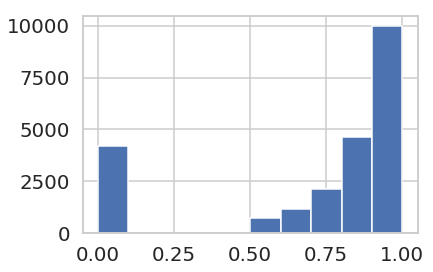

In [79]:
plt.hist(gal0['pz0'][missing0])

In [83]:
cids_all, ca0 = np.array(np.unique(gal0['CID'][true0&zmask0],return_counts=True))
cids_missing, c0 = np.array(np.unique(gal0['CID'][pmask0&true0&zmask0],return_counts=True))
cids_missing.size

import esutil
match0 = esutil.numpy_util.match(cids_all,cids_missing)
fmiss0 = 1.*c0[match0[1]]/ca0[match0[0]]

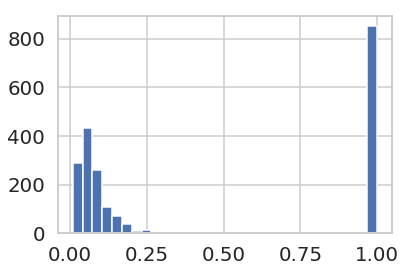

In [88]:
_ = plt.hist(fmiss0,bins=31)

In [87]:
cids_all1, ca1 = np.array(np.unique(gal1['CID'][true1&zmask1],return_counts=True))
cids_missing1, c1 = np.array(np.unique(gal1['CID'][pmask1&true1&zmask1],return_counts=True))
cids_missing1.size

import esutil
match1 = esutil.numpy_util.match(cids_all1,cids_missing1)
fmiss1 = 1.*c1[match1[1]]/ca1[match1[0]]

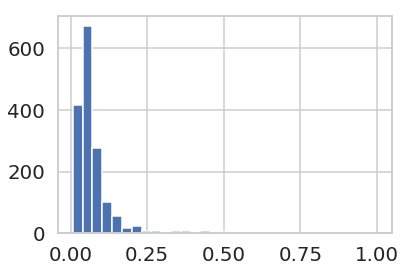

In [90]:
_ = plt.hist(fmiss1,bins=31)

In [100]:
missed_cids = cids_missing[match0[1]][fmiss0>0.95]

(array([ 951.,    0.,    0.,    0.,   15.,  689., 1103., 2035., 4496.,
        9738.]),
 array([0.        , 0.10011281, 0.20022563, 0.30033844, 0.40045126,
        0.50056407, 0.60067689, 0.7007897 , 0.80090252, 0.90101533,
        1.00112815]),
 <a list of 10 Patch objects>)

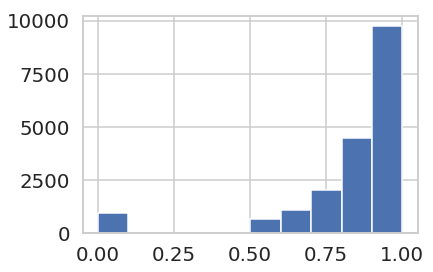

In [178]:
gid = np.array(gal0['CID'])
cidm, gidm = esutil.numpy_util.match(missed_cids,gid)
plt.hist(gal0[gidm[(pmask0&true0)[gidm]]]['pz0'])

(array([3540.,    0.,    0.,    0.,    0.,    6.,   15.,   17.,   26.,
          53.]),
 array([0.        , 0.09547965, 0.19095931, 0.28643896, 0.38191861,
        0.47739827, 0.57287792, 0.66835757, 0.76383722, 0.85931688,
        0.95479653]),
 <a list of 10 Patch objects>)

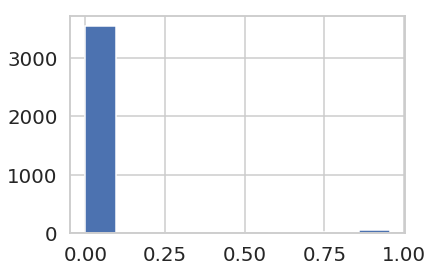

In [176]:
gid1 = np.array(gal1['CID'])
cidm1, gidm1 = esutil.numpy_util.match(cids_missing,gid1)
# plt.hist(gal1[gidm1]['pz0'])
plt.hist(gal1[gidm1[(pmask1&true1)[gidm1]]]['pz0'])

(array([5.110e+02, 2.954e+03, 7.045e+03, 6.925e+03, 1.040e+04, 7.525e+03,
        3.114e+03, 6.540e+02, 7.200e+01, 3.000e+00]),
 array([-0.39585814, -0.28535826, -0.17485837, -0.06435849,  0.04614139,
         0.15664127,  0.26714116,  0.37764104,  0.48814092,  0.59864081,
         0.70914069]),
 <a list of 10 Patch objects>)

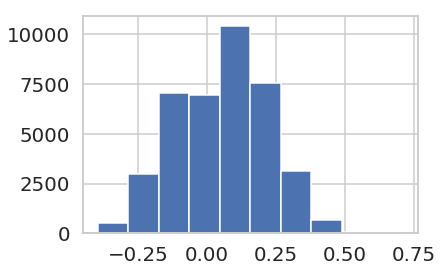

In [121]:
plt.hist(gal0[gidm][gal0['pz0'][gidm]<0.01]['zoffset'])

In [122]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")
from main import copacabana

cfg = root+'config_buzzard_v2.yaml'
copa = copacabana(cfg,dataset='buzzard_v2')
cat = copa.load_copa_out('cluster',runs[0])
cat1 = copa.load_copa_out('cluster',runs[1])

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00000.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00016.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00017.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00018.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00019.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00020.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00022.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00032.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00034.hdf5
/data/des61.a/data/johnny

In [110]:
sel = esutil.numpy_util.match(missed_cids, cat['CID'])[1]
cat[sel]

CID,Ngals,Area_bkg,DA,MU_TRUE_ERR_JK,RAPER,MU_ERR_JK,DEC,Ngals_true,Ngals_old,Area,Norm,tile,MU_TRUE,RA,R200,Nbkg_Counts,redshift,magLim_i,MASKFRAC,Nbkg_Counts_true,M200_true,MU,R200_true,Nbkg_true,Nbkg,Ngals_flat
int64,float64,float64,float64,float64,float64,float64,float32,int64,float64,float64,float64,int64,float64,float32,float64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float64,float64
7883038,0.0,128.22827157509357,466.1386265441721,33.76328369277483,1.1270912805566269,0.0,-18.236046,18,20.35301702172883,3.990874332986602,22.795559730058084,16,125.15939024202214,15.803826,1.1270912805566269,1.5207254812430602,0.12604478709744338,17.79880616775398,0.0,0.7517149751380235,75110000000000.0,0.0,0.90817,0.45301364164469216,0.45301364164469216,20.353017021970476
8182515,0.0,128.22827157509357,541.2202581808932,123.24996567787159,1.5178017801780177,0.0,-18.512892,38,43.769769846009396,7.237356877383949,45.87116798853538,16,385.80038252219737,15.412553,1.5178017801780177,1.3725522292245056,0.15035109353202264,18.204915309448317,0.0,0.6908599485572591,252600000000000.0,0.0,1.37099,0.46919152254285645,0.46919152254285645,43.76976984893844
8202088,-1.0,128.22827157509357,694.5486523207462,12.464924126272681,0.6048319117626048,0.0,-20.957836,7,-1.0,1.1492625814178563,10.20445188320744,16,32.79077709118886,14.2203045,0.6048319117626048,0.740866260092773,0.20466429254961124,18.905971510595336,0.0,0.0,134300000000000.0,0.0,1.127813,0.0,0.0,-1.0
8220667,0.0,128.22827157509357,648.8522829348854,79.59199269042503,1.0392539253925392,0.0,-25.9027,17,21.566494405481645,3.3930731288068956,24.705958177144144,16,155.23258480266853,7.1173286,1.0392539253925392,1.2789691226864712,0.18775814364585344,18.710855867396095,0.0,0.5894361612840507,335300000000000.0,0.0,1.523124,0.38438835961794754,0.38438835961794754,21.56649440567162
8239975,0.0,128.22827157509357,671.3733658947739,68.02656409190986,1.2298444130127297,0.0,-34.100655,33,31.97827911701672,4.75171317596245,35.00277385820006,16,228.6480677230668,4.950421,1.2298444130127297,1.2555733460519627,0.1960085565556374,18.80609412211201,0.0,0.4209008258573823,259100000000000.0,0.0,1.400548,0.3905839362473508,0.3905839362473508,31.978279117672088
8258718,0.0,128.22827157509357,775.4465381161373,41.28981574931913,1.4912848427699914,0.0,-38.084793,32,39.351215000653774,6.986683665211173,40.06412828031235,16,241.9664911736714,358.75348,1.4912848427699914,1.8248705774916723,0.23629237780790946,19.242923778079096,0.0,1.0019059593115878,250100000000000.0,0.0,1.398573,0.778583180924887,0.778583180924887,39.35121500174341
8278320,0.0,128.22827157509357,815.1906175927836,23.42445894954653,0.7916934550597916,0.0,-36.416798,7,8.519955842932058,1.969082815174051,8.363408473421492,16,44.17998990874934,2.040583,0.7916934550597916,1.2789691226864712,0.25270552416969017,19.407055241696902,0.0,0.5078506563024411,113900000000000.0,0.0,1.080592,0.2653520569765991,0.2653520569765991,8.519955843030894
8278804,-1.0,128.22827157509357,850.211322002545,20.996700816909986,0.654965496549655,0.0,-36.95528,6,-1.0,1.3476797934665627,6.426560880067651,16,59.17512661066223,359.0308,0.654965496549655,1.2165803849944483,0.26769217441957693,19.55692174419577,0.0,0.0,55720000000000.0,0.0,0.854473,0.0,0.0,-1.0
8504568,0.0,128.22827157509357,714.7663960210228,86.33681323817972,1.5236023602360234,0.0,-17.374788,39,46.6446004886045,7.292780566596778,48.206754657592114,16,290.58044540229577,19.36722,1.5236023602360234,1.2711705304749683,0.21235768360462337,18.995934519650856,0.0,0.9598533695175466,427600000000000.0,0.0,1.662705,0.8101921394773536,0.8101921394773536,46.64460049002476


In [112]:
np.unique(cat[sel]['tile'])

16
17
18
20
32
33
34
35
38
44
45


The are two main issues with the `gaussian001` run: 
    <li> Cluster Catalog: computing ngals (zero values); computing pmem (zero values)
   </li>

In [146]:
len(cat1)

2748

In [147]:
len(cat)

2748

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


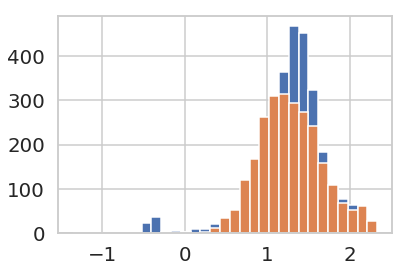

In [144]:
good = cat['Ngals_flat']>0.
_ = plt.hist(np.log10(cat1['Ngals']),bins=31)
_ = plt.hist(np.log10(cat['Ngals_flat'])[good],bins=_[1])